In [29]:
%load_ext autoreload
%autoreload 2

import os
import time

import numpy as np

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader
from torchvision import transforms


from datasets import BadNetsDataset, WaNetDataset, SIGDataset
from simclr import SimClrBackbone

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
device = "cuda"
epochs = 300
batch_size = 128

In [31]:
LOAD_CHECKPOINT = False
CHECKPOINT_NAME = "SIG-60-SimCLR-140.pt"

DATASET = "sig40"

if DATASET == "badnets":
    TARGET_CLASS = 1
elif DATASET == "wanet":
    TARGET_CLASS = 0
elif DATASET == "sig":
    TARGET_CLASS = 0
elif DATASET == "sig40":
    TARGET_CLASS = 0
else:
    raise Exception("Invalid dataset")

## Poison dataset

In [32]:
dataset = torchvision.datasets.CIFAR10(root='C:/Datasets', train=True, download=True)

if DATASET == "badnets":
    poison_dataset = BadNetsDataset(dataset, TARGET_CLASS, "triggers/trigger_10.png", seed=1)
elif DATASET == "wanet":
    poison_dataset = WaNetDataset(dataset, TARGET_CLASS, seed=1)
elif DATASET == "sig":
    poison_dataset = SIGDataset(dataset, TARGET_CLASS, 20, 6, seed=1)
elif DATASET == "sig40":
    poison_dataset = SIGDataset(dataset, TARGET_CLASS, 20, 6, alpha=0.4, seed=2)
else:
    raise Exception("Invalid dataset")

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## SimCLR data augmentations

In [33]:
class ConstrastiveDataset(VisionDataset):

    def __init__(self, original_dataset: VisionDataset, s: int = 0.5):
        self.original_dataset = original_dataset

        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomResizedCrop(32,(0.8,1.0),antialias=False),
            transforms.Compose([transforms.RandomApply([
                transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p = 0.8),
                transforms.RandomGrayscale(p=0.2)]),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
            ])
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, index):
        img = self.original_dataset[index][0]
        augmented_img_1 = self.transforms(img)
        augmented_img_2 = self.transforms(img)
        return augmented_img_1, augmented_img_2
    
constrastive_dataset = ConstrastiveDataset(poison_dataset)

## SimCLR model

In [34]:
model = SimClrBackbone()
model = model.to(device)

c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## LARS optimizer

In [35]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

## SimCLR contrastive loss

In [36]:
class SimCLR_Loss(nn.Module):
    def __init__(self, temperature):
        super(SimCLR_Loss, self).__init__()
        self.temperature = temperature

        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
            
        return mask

    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        batch_size = z_i.shape[0]
        mask = self.mask_correlated_samples(batch_size)

        N = 2 * batch_size #* self.world_size
        
        #z_i_ = z_i / torch.sqrt(torch.sum(torch.square(z_i),dim = 1, keepdim = True))
        #z_j_ = z_j / torch.sqrt(torch.sum(torch.square(z_j),dim = 1, keepdim = True))

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        
        #print(sim.shape)

        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, batch_size)
        
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[mask].reshape(N, -1)
        
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        #labels was torch.zeros(N)
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

## Training

In [37]:
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = False)
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = False)

criterion = SimCLR_Loss(temperature=0.5)

dataloader = DataLoader(constrastive_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_no_contrastive = DataLoader(poison_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

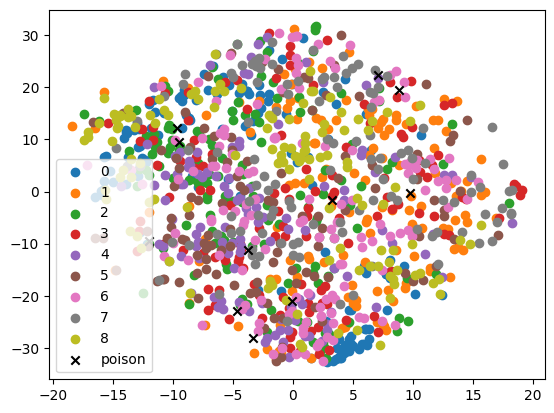

In [38]:
from sklearn.manifold import TSNE

def plot_features(model: nn.Module, dataloader: DataLoader, batches: int = None):
    model.eval()

    features = None
    labels_poison = None
    labels_true = None

    for i, (img, labels_batch_poison, labels_batch_true) in enumerate(dataloader):

        if batches is not None and i>=batches:
            break
    
        with torch.no_grad():
            features_batch = model(img.to(device)).cpu().data.numpy()
            
        if features is None:
            features = features_batch
            labels_poison = labels_batch_poison
            labels_true = labels_batch_true
        else:
            features = np.append(features, features_batch, axis=0)
            labels_poison = np.append(labels_poison, labels_batch_poison, axis=0)
            labels_true = np.append(labels_true, labels_batch_true, axis=0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    tsne_features = tsne.fit_transform(features)
    num_classes = max(labels_batch_poison)

    labels = labels_true[:]
    labels[[poison_dataset.is_poison(i) for i in range(len(labels))]] = 10

    for i in range(num_classes):
        plt.scatter(tsne_features[labels==i,1], tsne_features[labels==i,0])
    plt.scatter(tsne_features[labels==10,1], tsne_features[labels==10,0], c = "black", marker= "x")

    plt.legend([str(i) for i in range(num_classes)] + ["poison"])
    plt.show()

    model.train()

plot_features(model, dataloader_no_contrastive, 10)

In [39]:
def train(dataloader, model, criterion, optimizer):
    loss_epoch = 0
    
    for step, (x_i, x_j) in enumerate(dataloader):
        optimizer.zero_grad()
        x_i = x_i.to(device).float()
        x_j = x_j.to(device).float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        
        if step % 50 == 0:
            print(f"\tStep [{step}/{len(dataloader)}]\t Loss: {round(loss.item(), 5)}")

        loss_epoch += loss.item()
    return loss_epoch / len(dataloader)

In [40]:
def save_model(model, optimizer, scheduler, epoch, name):
    out = os.path.join('./saved_models/', name)

    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'epoch': epoch
                }, out)

    print(f"\tSaved model, optimizer, scheduler and epoch info to {out}")

In [41]:
start_epoch = 0

load_checkpoint = False
checkpoint_name = "WaNet-SimCLR_150.pt"

if LOAD_CHECKPOINT:
    out = os.path.join('./saved_models/', CHECKPOINT_NAME)
    checkpoint = torch.load(out, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    mainscheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    start_epoch = checkpoint["epoch"] + 1

Epoch [0/300]	
	Step [0/391]	 Loss: 5.15535
	Step [50/391]	 Loss: 4.45385
	Step [100/391]	 Loss: 4.1098
	Step [150/391]	 Loss: 3.96072
	Step [200/391]	 Loss: 3.89064
	Step [250/391]	 Loss: 3.82776
	Step [300/391]	 Loss: 3.79628
	Step [350/391]	 Loss: 3.79529

	Training Loss: 4.030446820246899
	Time Taken: 3.736600470542908 minutes
	Saved model, optimizer, scheduler and epoch info to ./saved_models/NEW-SimCLR-0.pt


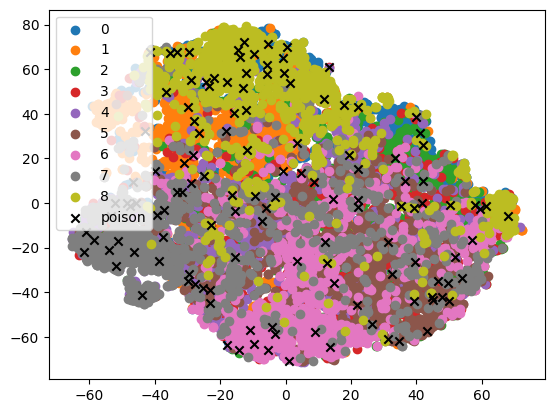

Epoch [1/300]	
	Step [0/391]	 Loss: 3.76656
	Step [50/391]	 Loss: 3.79515
	Step [100/391]	 Loss: 3.74542
	Step [150/391]	 Loss: 3.76821
	Step [200/391]	 Loss: 3.75861
	Step [250/391]	 Loss: 3.75041
	Step [300/391]	 Loss: 3.77645
	Step [350/391]	 Loss: 3.75988

	Training Loss: 3.7589889694662655
	Time Taken: 3.7274166703224183 minutes
Epoch [2/300]	
	Step [0/391]	 Loss: 3.75893
	Step [50/391]	 Loss: 3.75912
	Step [100/391]	 Loss: 3.76335
	Step [150/391]	 Loss: 3.72688
	Step [200/391]	 Loss: 3.74572
	Step [250/391]	 Loss: 3.7319
	Step [300/391]	 Loss: 3.72015
	Step [350/391]	 Loss: 3.7309

	Training Loss: 3.7411660489523806
	Time Taken: 3.671766686439514 minutes
Epoch [3/300]	
	Step [0/391]	 Loss: 3.73386
	Step [50/391]	 Loss: 3.73712
	Step [100/391]	 Loss: 3.74496
	Step [150/391]	 Loss: 3.72331
	Step [200/391]	 Loss: 3.73595
	Step [250/391]	 Loss: 3.7291
	Step [300/391]	 Loss: 3.73935
	Step [350/391]	 Loss: 3.72671

	Training Loss: 3.72601606047062
	Time Taken: 3.6118999481201173 minute

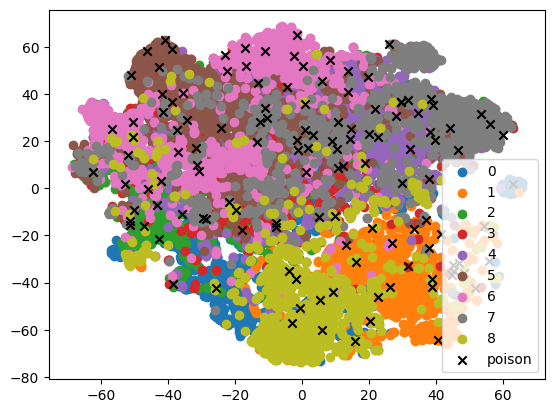

Epoch [11/300]	
	Step [0/391]	 Loss: 3.66338
	Step [50/391]	 Loss: 3.66435
	Step [100/391]	 Loss: 3.66267
	Step [150/391]	 Loss: 3.66098
	Step [200/391]	 Loss: 3.66695
	Step [250/391]	 Loss: 3.6601
	Step [300/391]	 Loss: 3.66542
	Step [350/391]	 Loss: 3.66

	Training Loss: 3.6651029074588397
	Time Taken: 3.6231666644414267 minutes
Epoch [12/300]	
	Step [0/391]	 Loss: 3.66625
	Step [50/391]	 Loss: 3.66303
	Step [100/391]	 Loss: 3.66092
	Step [150/391]	 Loss: 3.67412
	Step [200/391]	 Loss: 3.65158
	Step [250/391]	 Loss: 3.64755
	Step [300/391]	 Loss: 3.65968
	Step [350/391]	 Loss: 3.65611

	Training Loss: 3.6595177729721264
	Time Taken: 3.6275166471799216 minutes
Epoch [13/300]	
	Step [0/391]	 Loss: 3.65202
	Step [50/391]	 Loss: 3.65853
	Step [100/391]	 Loss: 3.66785
	Step [150/391]	 Loss: 3.64366
	Step [200/391]	 Loss: 3.66625
	Step [250/391]	 Loss: 3.66166
	Step [300/391]	 Loss: 3.66353
	Step [350/391]	 Loss: 3.67081

	Training Loss: 3.6572295143781113
	Time Taken: 3.611733369032542 mi

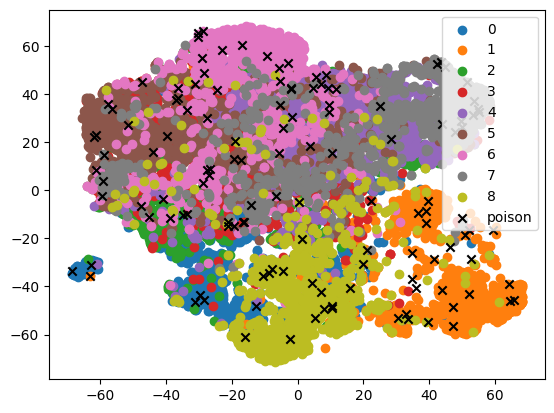

Epoch [21/300]	
	Step [0/391]	 Loss: 3.64493
	Step [50/391]	 Loss: 3.64183
	Step [100/391]	 Loss: 3.65012
	Step [150/391]	 Loss: 3.63642
	Step [200/391]	 Loss: 3.65308
	Step [250/391]	 Loss: 3.64122
	Step [300/391]	 Loss: 3.634
	Step [350/391]	 Loss: 3.6345

	Training Loss: 3.6405930354467135
	Time Taken: 3.6233833193778993 minutes
Epoch [22/300]	
	Step [0/391]	 Loss: 3.63899
	Step [50/391]	 Loss: 3.64058
	Step [100/391]	 Loss: 3.63332
	Step [150/391]	 Loss: 3.64063
	Step [200/391]	 Loss: 3.63894
	Step [250/391]	 Loss: 3.64351
	Step [300/391]	 Loss: 3.65014
	Step [350/391]	 Loss: 3.63746

	Training Loss: 3.6390057530854363
	Time Taken: 3.6442333340644835 minutes
Epoch [23/300]	
	Step [0/391]	 Loss: 3.62819
	Step [50/391]	 Loss: 3.63564
	Step [100/391]	 Loss: 3.63904
	Step [150/391]	 Loss: 3.64002
	Step [200/391]	 Loss: 3.63184
	Step [250/391]	 Loss: 3.63645
	Step [300/391]	 Loss: 3.63209
	Step [350/391]	 Loss: 3.64119

	Training Loss: 3.637696950331978
	Time Taken: 3.616716663042704 mi

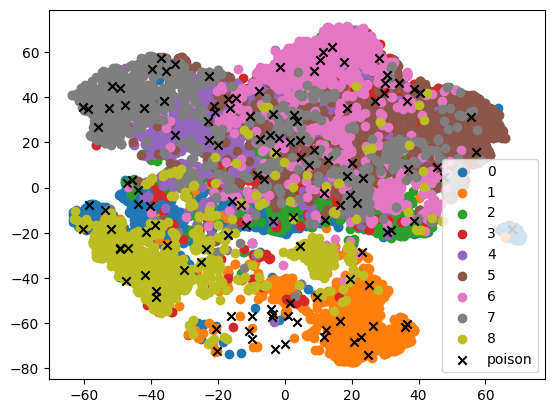

Epoch [31/300]	
	Step [0/391]	 Loss: 3.63006
	Step [50/391]	 Loss: 3.6429
	Step [100/391]	 Loss: 3.62896
	Step [150/391]	 Loss: 3.62251
	Step [200/391]	 Loss: 3.62502
	Step [250/391]	 Loss: 3.63429
	Step [300/391]	 Loss: 3.63491
	Step [350/391]	 Loss: 3.62481

	Training Loss: 3.630078194391392
	Time Taken: 3.6307833035786947 minutes
Epoch [32/300]	
	Step [0/391]	 Loss: 3.63845
	Step [50/391]	 Loss: 3.62177
	Step [100/391]	 Loss: 3.62424
	Step [150/391]	 Loss: 3.63495
	Step [200/391]	 Loss: 3.62774
	Step [250/391]	 Loss: 3.6369
	Step [300/391]	 Loss: 3.63528
	Step [350/391]	 Loss: 3.63111

	Training Loss: 3.6289602807720605
	Time Taken: 3.6306500514348348 minutes
Epoch [33/300]	
	Step [0/391]	 Loss: 3.63524
	Step [50/391]	 Loss: 3.62978
	Step [100/391]	 Loss: 3.6327
	Step [150/391]	 Loss: 3.62126
	Step [200/391]	 Loss: 3.63325
	Step [250/391]	 Loss: 3.62507
	Step [300/391]	 Loss: 3.6256
	Step [350/391]	 Loss: 3.62448

	Training Loss: 3.628143766651983
	Time Taken: 3.6251666148503623 min

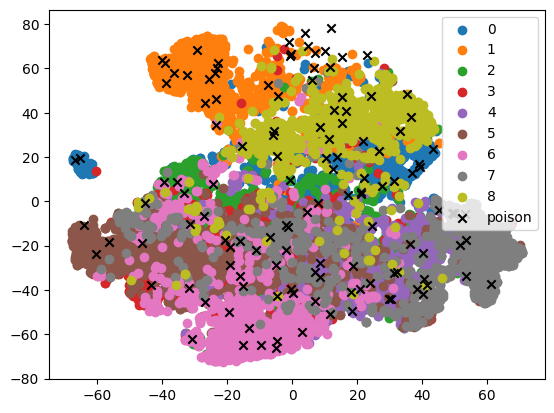

Epoch [41/300]	
	Step [0/391]	 Loss: 3.62256
	Step [50/391]	 Loss: 3.62924
	Step [100/391]	 Loss: 3.62662
	Step [150/391]	 Loss: 3.62474
	Step [200/391]	 Loss: 3.628
	Step [250/391]	 Loss: 3.61977
	Step [300/391]	 Loss: 3.61818
	Step [350/391]	 Loss: 3.62994

	Training Loss: 3.6233042329168685
	Time Taken: 3.614699979623159 minutes
Epoch [42/300]	
	Step [0/391]	 Loss: 3.62209
	Step [50/391]	 Loss: 3.61863
	Step [100/391]	 Loss: 3.62938
	Step [150/391]	 Loss: 3.62548
	Step [200/391]	 Loss: 3.62625
	Step [250/391]	 Loss: 3.62172
	Step [300/391]	 Loss: 3.61781
	Step [350/391]	 Loss: 3.61558

	Training Loss: 3.6223326192792418
	Time Taken: 3.6996833602587382 minutes
Epoch [43/300]	
	Step [0/391]	 Loss: 3.62959
	Step [50/391]	 Loss: 3.61558
	Step [100/391]	 Loss: 3.61467
	Step [150/391]	 Loss: 3.62672
	Step [200/391]	 Loss: 3.61948
	Step [250/391]	 Loss: 3.61577
	Step [300/391]	 Loss: 3.61702
	Step [350/391]	 Loss: 3.61462

	Training Loss: 3.621980296376416
	Time Taken: 3.6217833439509075 m

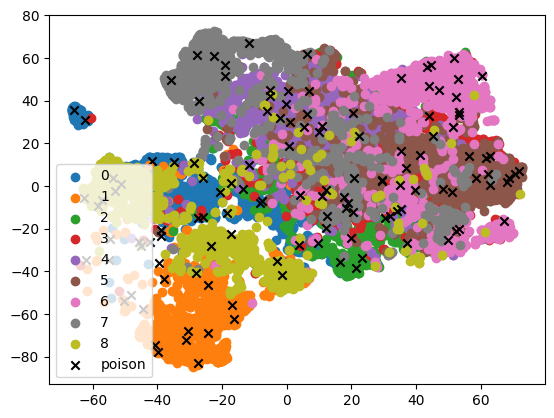

Epoch [51/300]	
	Step [0/391]	 Loss: 3.62062
	Step [50/391]	 Loss: 3.61906
	Step [100/391]	 Loss: 3.61639
	Step [150/391]	 Loss: 3.61336
	Step [200/391]	 Loss: 3.617
	Step [250/391]	 Loss: 3.61469
	Step [300/391]	 Loss: 3.61951
	Step [350/391]	 Loss: 3.62112

	Training Loss: 3.618442754916218
	Time Taken: 3.629186216990153 minutes
Epoch [52/300]	
	Step [0/391]	 Loss: 3.61425
	Step [50/391]	 Loss: 3.63131
	Step [100/391]	 Loss: 3.61877
	Step [150/391]	 Loss: 3.61456
	Step [200/391]	 Loss: 3.61888
	Step [250/391]	 Loss: 3.61128
	Step [300/391]	 Loss: 3.61837
	Step [350/391]	 Loss: 3.6107

	Training Loss: 3.6179585066597784
	Time Taken: 3.627802920341492 minutes
Epoch [53/300]	
	Step [0/391]	 Loss: 3.61244
	Step [50/391]	 Loss: 3.6148
	Step [100/391]	 Loss: 3.61453
	Step [150/391]	 Loss: 3.61124
	Step [200/391]	 Loss: 3.60729
	Step [250/391]	 Loss: 3.62077
	Step [300/391]	 Loss: 3.61026
	Step [350/391]	 Loss: 3.62057

	Training Loss: 3.617031203511426
	Time Taken: 3.612569582462311 minute

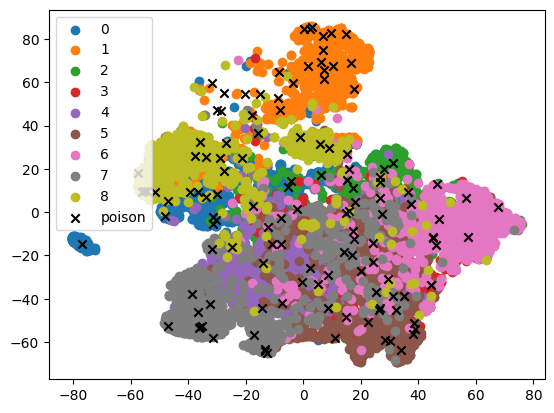

Epoch [61/300]	
	Step [0/391]	 Loss: 3.60948
	Step [50/391]	 Loss: 3.61382
	Step [100/391]	 Loss: 3.61223
	Step [150/391]	 Loss: 3.62323
	Step [200/391]	 Loss: 3.61757
	Step [250/391]	 Loss: 3.61065
	Step [300/391]	 Loss: 3.62178
	Step [350/391]	 Loss: 3.61598

	Training Loss: 3.614458771312938
	Time Taken: 3.621984803676605 minutes
Epoch [62/300]	
	Step [0/391]	 Loss: 3.6244
	Step [50/391]	 Loss: 3.61693
	Step [100/391]	 Loss: 3.61567
	Step [150/391]	 Loss: 3.61859
	Step [200/391]	 Loss: 3.61555
	Step [250/391]	 Loss: 3.62042
	Step [300/391]	 Loss: 3.61953
	Step [350/391]	 Loss: 3.61178

	Training Loss: 3.614097090328441
	Time Taken: 3.630434759457906 minutes
Epoch [63/300]	
	Step [0/391]	 Loss: 3.62335
	Step [50/391]	 Loss: 3.61463
	Step [100/391]	 Loss: 3.62193
	Step [150/391]	 Loss: 3.61343
	Step [200/391]	 Loss: 3.61146
	Step [250/391]	 Loss: 3.61119
	Step [300/391]	 Loss: 3.614
	Step [350/391]	 Loss: 3.62143

	Training Loss: 3.6140375582458417
	Time Taken: 3.6226179043451947 minu

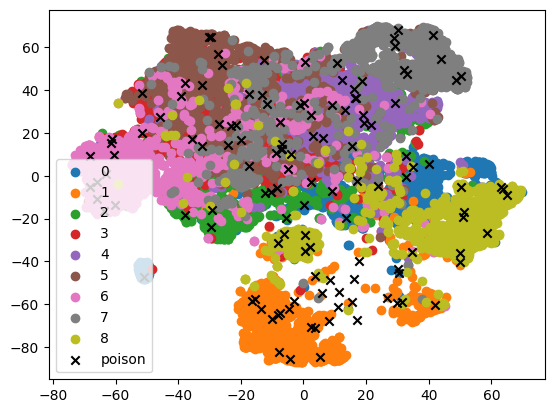

Epoch [71/300]	
	Step [0/391]	 Loss: 3.61382
	Step [50/391]	 Loss: 3.62131
	Step [100/391]	 Loss: 3.61874
	Step [150/391]	 Loss: 3.6162
	Step [200/391]	 Loss: 3.61221
	Step [250/391]	 Loss: 3.61677
	Step [300/391]	 Loss: 3.61501
	Step [350/391]	 Loss: 3.61699

	Training Loss: 3.6117104038862924
	Time Taken: 3.6301674087842306 minutes
Epoch [72/300]	
	Step [0/391]	 Loss: 3.6105
	Step [50/391]	 Loss: 3.61178
	Step [100/391]	 Loss: 3.62318
	Step [150/391]	 Loss: 3.61704
	Step [200/391]	 Loss: 3.60954
	Step [250/391]	 Loss: 3.61616
	Step [300/391]	 Loss: 3.61329
	Step [350/391]	 Loss: 3.61166

	Training Loss: 3.611568110068436
	Time Taken: 3.6316505908966064 minutes
Epoch [73/300]	
	Step [0/391]	 Loss: 3.61761
	Step [50/391]	 Loss: 3.61307
	Step [100/391]	 Loss: 3.61098
	Step [150/391]	 Loss: 3.61033
	Step [200/391]	 Loss: 3.61856
	Step [250/391]	 Loss: 3.61581
	Step [300/391]	 Loss: 3.60899
	Step [350/391]	 Loss: 3.61386

	Training Loss: 3.610790722815277
	Time Taken: 3.6277003486951194 m

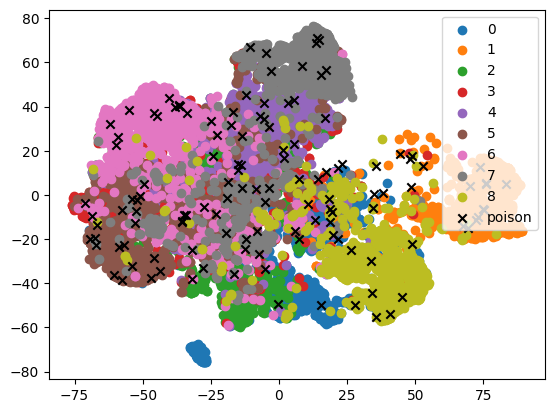

Epoch [81/300]	
	Step [0/391]	 Loss: 3.60888
	Step [50/391]	 Loss: 3.60661
	Step [100/391]	 Loss: 3.61275
	Step [150/391]	 Loss: 3.61284
	Step [200/391]	 Loss: 3.6129
	Step [250/391]	 Loss: 3.60397
	Step [300/391]	 Loss: 3.60592
	Step [350/391]	 Loss: 3.60966

	Training Loss: 3.6085664122305867
	Time Taken: 3.628033685684204 minutes
Epoch [82/300]	
	Step [0/391]	 Loss: 3.61091
	Step [50/391]	 Loss: 3.61336
	Step [100/391]	 Loss: 3.61676
	Step [150/391]	 Loss: 3.60664
	Step [200/391]	 Loss: 3.61519
	Step [250/391]	 Loss: 3.61259
	Step [300/391]	 Loss: 3.60543
	Step [350/391]	 Loss: 3.60693

	Training Loss: 3.608635070683706
	Time Taken: 3.626567041873932 minutes
Epoch [83/300]	
	Step [0/391]	 Loss: 3.61028
	Step [50/391]	 Loss: 3.61136
	Step [100/391]	 Loss: 3.60754
	Step [150/391]	 Loss: 3.60588
	Step [200/391]	 Loss: 3.61142
	Step [250/391]	 Loss: 3.61575
	Step [300/391]	 Loss: 3.60961
	Step [350/391]	 Loss: 3.60989

	Training Loss: 3.608093294646124
	Time Taken: 3.6241337060928345 mi

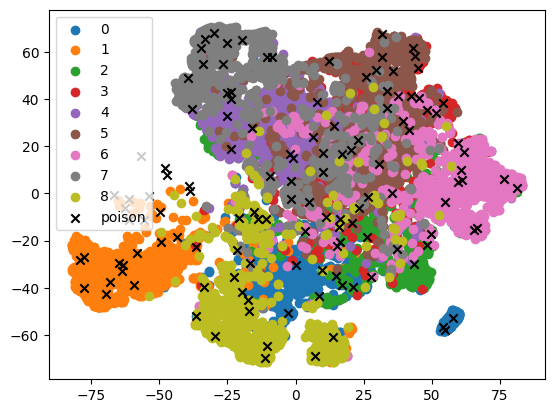

Epoch [91/300]	
	Step [0/391]	 Loss: 3.61108
	Step [50/391]	 Loss: 3.61421
	Step [100/391]	 Loss: 3.60817
	Step [150/391]	 Loss: 3.60398
	Step [200/391]	 Loss: 3.61072
	Step [250/391]	 Loss: 3.61165
	Step [300/391]	 Loss: 3.60641
	Step [350/391]	 Loss: 3.60858

	Training Loss: 3.606292684364807
	Time Taken: 3.624000346660614 minutes
Epoch [92/300]	
	Step [0/391]	 Loss: 3.60771
	Step [50/391]	 Loss: 3.60382
	Step [100/391]	 Loss: 3.60616
	Step [150/391]	 Loss: 3.60509
	Step [200/391]	 Loss: 3.60343
	Step [250/391]	 Loss: 3.6069
	Step [300/391]	 Loss: 3.60989
	Step [350/391]	 Loss: 3.61544

	Training Loss: 3.6059995026844542
	Time Taken: 3.6297003587086993 minutes
Epoch [93/300]	
	Step [0/391]	 Loss: 3.60255
	Step [50/391]	 Loss: 3.60054
	Step [100/391]	 Loss: 3.61354
	Step [150/391]	 Loss: 3.60322
	Step [200/391]	 Loss: 3.60811
	Step [250/391]	 Loss: 3.60102
	Step [300/391]	 Loss: 3.61098
	Step [350/391]	 Loss: 3.61001

	Training Loss: 3.606109925853017
	Time Taken: 3.6172003944714866 m

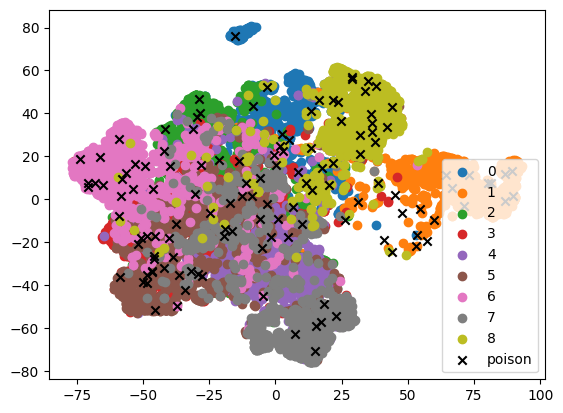

Epoch [101/300]	
	Step [0/391]	 Loss: 3.60998
	Step [50/391]	 Loss: 3.60825
	Step [100/391]	 Loss: 3.60248
	Step [150/391]	 Loss: 3.6059
	Step [200/391]	 Loss: 3.60256
	Step [250/391]	 Loss: 3.6003
	Step [300/391]	 Loss: 3.60454
	Step [350/391]	 Loss: 3.61258

	Training Loss: 3.6040920790504005
	Time Taken: 3.624500032265981 minutes
Epoch [102/300]	
	Step [0/391]	 Loss: 3.60407
	Step [50/391]	 Loss: 3.60834
	Step [100/391]	 Loss: 3.60484
	Step [150/391]	 Loss: 3.60058
	Step [200/391]	 Loss: 3.60517
	Step [250/391]	 Loss: 3.59788
	Step [300/391]	 Loss: 3.60215
	Step [350/391]	 Loss: 3.6101

	Training Loss: 3.604500046776384
	Time Taken: 3.627416650454203 minutes
Epoch [103/300]	
	Step [0/391]	 Loss: 3.6094
	Step [50/391]	 Loss: 3.60135
	Step [100/391]	 Loss: 3.60733
	Step [150/391]	 Loss: 3.60471
	Step [200/391]	 Loss: 3.60325
	Step [250/391]	 Loss: 3.60812
	Step [300/391]	 Loss: 3.59744
	Step [350/391]	 Loss: 3.60664

	Training Loss: 3.603890570838128
	Time Taken: 3.6166332999865216 mi

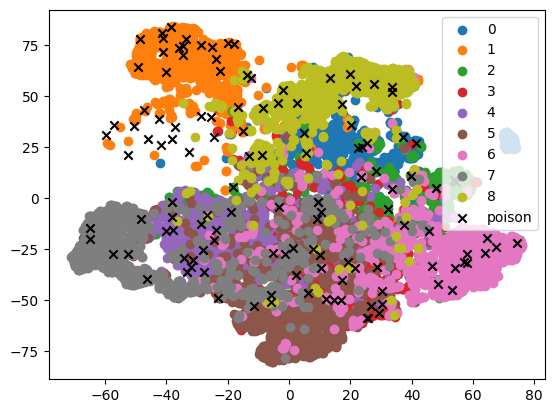

Epoch [111/300]	
	Step [0/391]	 Loss: 3.60188
	Step [50/391]	 Loss: 3.60385
	Step [100/391]	 Loss: 3.59962
	Step [150/391]	 Loss: 3.60336
	Step [200/391]	 Loss: 3.60501
	Step [250/391]	 Loss: 3.61358
	Step [300/391]	 Loss: 3.6005
	Step [350/391]	 Loss: 3.60341

	Training Loss: 3.6024493774794557
	Time Taken: 3.62585000594457 minutes
Epoch [112/300]	
	Step [0/391]	 Loss: 3.60664
	Step [50/391]	 Loss: 3.60289
	Step [100/391]	 Loss: 3.61014
	Step [150/391]	 Loss: 3.60302
	Step [200/391]	 Loss: 3.60238
	Step [250/391]	 Loss: 3.59912
	Step [300/391]	 Loss: 3.60628
	Step [350/391]	 Loss: 3.60006

	Training Loss: 3.6025431192744417
	Time Taken: 3.628666655222575 minutes
Epoch [113/300]	
	Step [0/391]	 Loss: 3.60173
	Step [50/391]	 Loss: 3.59909
	Step [100/391]	 Loss: 3.60111
	Step [150/391]	 Loss: 3.60386
	Step [200/391]	 Loss: 3.60141
	Step [250/391]	 Loss: 3.60415
	Step [300/391]	 Loss: 3.6071
	Step [350/391]	 Loss: 3.59969

	Training Loss: 3.6021835377149265
	Time Taken: 3.6292333523432414

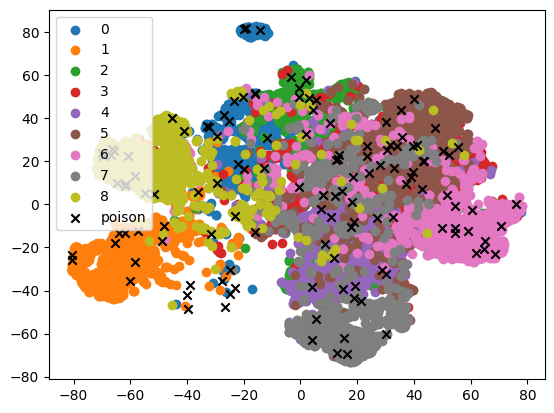

Epoch [121/300]	
	Step [0/391]	 Loss: 3.601
	Step [50/391]	 Loss: 3.60922
	Step [100/391]	 Loss: 3.60969
	Step [150/391]	 Loss: 3.60544
	Step [200/391]	 Loss: 3.60864
	Step [250/391]	 Loss: 3.59898
	Step [300/391]	 Loss: 3.60444
	Step [350/391]	 Loss: 3.60134

	Training Loss: 3.600701005867375
	Time Taken: 3.63273336092631 minutes
Epoch [122/300]	
	Step [0/391]	 Loss: 3.60206
	Step [50/391]	 Loss: 3.60253
	Step [100/391]	 Loss: 3.603
	Step [150/391]	 Loss: 3.60209
	Step [200/391]	 Loss: 3.60308
	Step [250/391]	 Loss: 3.6108
	Step [300/391]	 Loss: 3.59763
	Step [350/391]	 Loss: 3.60403

	Training Loss: 3.600450948681063
	Time Taken: 3.63262513478597 minutes
Epoch [123/300]	
	Step [0/391]	 Loss: 3.60588
	Step [50/391]	 Loss: 3.59986
	Step [100/391]	 Loss: 3.60093
	Step [150/391]	 Loss: 3.59625
	Step [200/391]	 Loss: 3.60047
	Step [250/391]	 Loss: 3.59988
	Step [300/391]	 Loss: 3.60447
	Step [350/391]	 Loss: 3.60058

	Training Loss: 3.6004266543766423
	Time Taken: 3.6277833382288613 minut

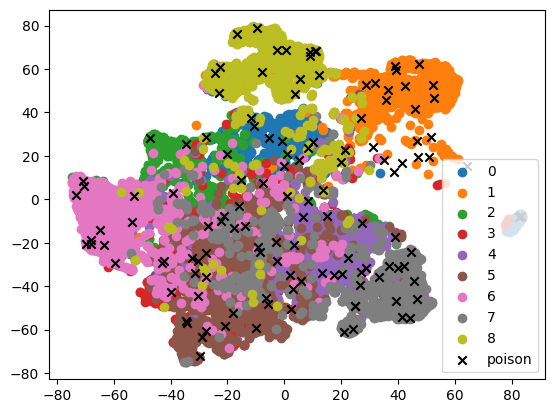

Epoch [131/300]	
	Step [0/391]	 Loss: 3.60135
	Step [50/391]	 Loss: 3.59565
	Step [100/391]	 Loss: 3.59863
	Step [150/391]	 Loss: 3.59999
	Step [200/391]	 Loss: 3.59867
	Step [250/391]	 Loss: 3.61618
	Step [300/391]	 Loss: 3.59796
	Step [350/391]	 Loss: 3.59838

	Training Loss: 3.5994904474224274
	Time Taken: 3.6277166604995728 minutes
Epoch [132/300]	
	Step [0/391]	 Loss: 3.60418
	Step [50/391]	 Loss: 3.6017
	Step [100/391]	 Loss: 3.60543
	Step [150/391]	 Loss: 3.59667
	Step [200/391]	 Loss: 3.60384
	Step [250/391]	 Loss: 3.60393
	Step [300/391]	 Loss: 3.59861
	Step [350/391]	 Loss: 3.60065

	Training Loss: 3.5990891023670013
	Time Taken: 3.622766681512197 minutes
Epoch [133/300]	
	Step [0/391]	 Loss: 3.59531
	Step [50/391]	 Loss: 3.60482
	Step [100/391]	 Loss: 3.60748
	Step [150/391]	 Loss: 3.59546
	Step [200/391]	 Loss: 3.60798
	Step [250/391]	 Loss: 3.60054
	Step [300/391]	 Loss: 3.60101
	Step [350/391]	 Loss: 3.60133

	Training Loss: 3.5989278076249924
	Time Taken: 3.6190499862035

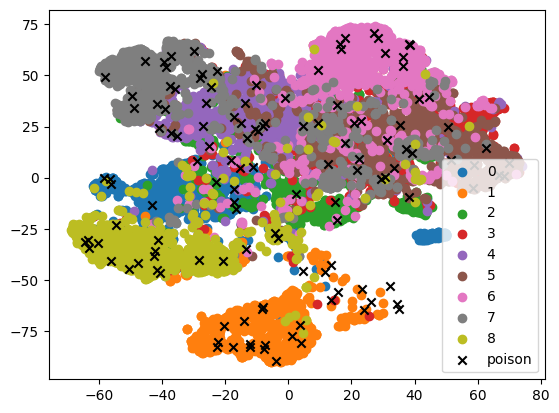

Epoch [141/300]	
	Step [0/391]	 Loss: 3.59569
	Step [50/391]	 Loss: 3.59591
	Step [100/391]	 Loss: 3.59735
	Step [150/391]	 Loss: 3.60478
	Step [200/391]	 Loss: 3.59975
	Step [250/391]	 Loss: 3.59781
	Step [300/391]	 Loss: 3.59905
	Step [350/391]	 Loss: 3.59348

	Training Loss: 3.5976394265509017
	Time Taken: 3.630049987634023 minutes
Epoch [142/300]	
	Step [0/391]	 Loss: 3.60377
	Step [50/391]	 Loss: 3.59687
	Step [100/391]	 Loss: 3.5945
	Step [150/391]	 Loss: 3.59592
	Step [200/391]	 Loss: 3.59519
	Step [250/391]	 Loss: 3.60158
	Step [300/391]	 Loss: 3.5994
	Step [350/391]	 Loss: 3.59514

	Training Loss: 3.598009577797502
	Time Taken: 3.6284499843915303 minutes
Epoch [143/300]	
	Step [0/391]	 Loss: 3.59833
	Step [50/391]	 Loss: 3.60193
	Step [100/391]	 Loss: 3.60203
	Step [150/391]	 Loss: 3.59729
	Step [200/391]	 Loss: 3.60152
	Step [250/391]	 Loss: 3.59686
	Step [300/391]	 Loss: 3.59838
	Step [350/391]	 Loss: 3.59927

	Training Loss: 3.5977986047944754
	Time Taken: 3.620883361498514

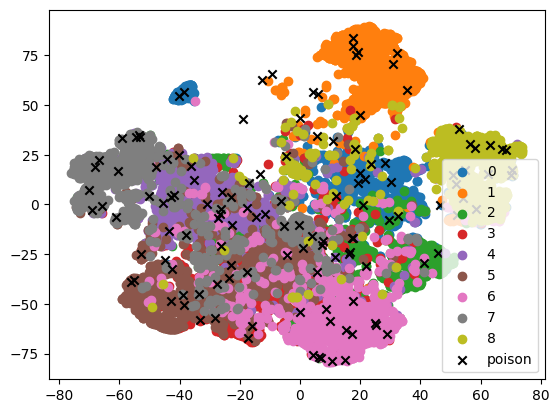

Epoch [151/300]	
	Step [0/391]	 Loss: 3.5931
	Step [50/391]	 Loss: 3.59714
	Step [100/391]	 Loss: 3.60016
	Step [150/391]	 Loss: 3.59624
	Step [200/391]	 Loss: 3.59796
	Step [250/391]	 Loss: 3.6036
	Step [300/391]	 Loss: 3.6001
	Step [350/391]	 Loss: 3.61509

	Training Loss: 3.596779602567863
	Time Taken: 3.6259999950726827 minutes
Epoch [152/300]	
	Step [0/391]	 Loss: 3.59924
	Step [50/391]	 Loss: 3.59822
	Step [100/391]	 Loss: 3.59482
	Step [150/391]	 Loss: 3.59461
	Step [200/391]	 Loss: 3.59894
	Step [250/391]	 Loss: 3.60252
	Step [300/391]	 Loss: 3.59882
	Step [350/391]	 Loss: 3.60168

	Training Loss: 3.596172154711945
	Time Taken: 3.630583341916402 minutes
Epoch [153/300]	
	Step [0/391]	 Loss: 3.60044
	Step [50/391]	 Loss: 3.59392
	Step [100/391]	 Loss: 3.5986
	Step [150/391]	 Loss: 3.59637
	Step [200/391]	 Loss: 3.59833
	Step [250/391]	 Loss: 3.60745
	Step [300/391]	 Loss: 3.60411
	Step [350/391]	 Loss: 3.59651

	Training Loss: 3.5960621632578427
	Time Taken: 3.6196666916211444 m

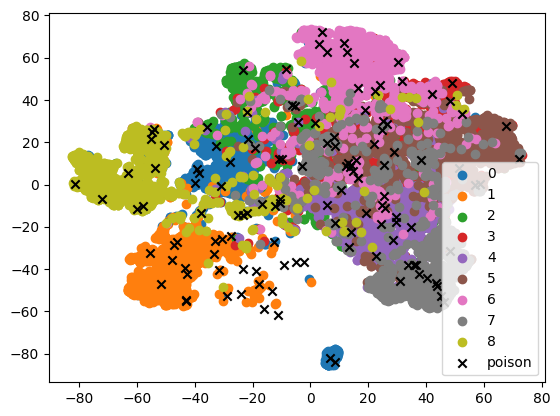

Epoch [161/300]	
	Step [0/391]	 Loss: 3.59832
	Step [50/391]	 Loss: 3.59579
	Step [100/391]	 Loss: 3.59602
	Step [150/391]	 Loss: 3.59731
	Step [200/391]	 Loss: 3.59751
	Step [250/391]	 Loss: 3.5917
	Step [300/391]	 Loss: 3.59505
	Step [350/391]	 Loss: 3.59618

	Training Loss: 3.5954867403220643
	Time Taken: 3.627692159016927 minutes
Epoch [162/300]	
	Step [0/391]	 Loss: 3.59636
	Step [50/391]	 Loss: 3.59465
	Step [100/391]	 Loss: 3.59377
	Step [150/391]	 Loss: 3.59231
	Step [200/391]	 Loss: 3.5936
	Step [250/391]	 Loss: 3.59555
	Step [300/391]	 Loss: 3.59527
	Step [350/391]	 Loss: 3.60361

	Training Loss: 3.5954920934594194
	Time Taken: 3.625066645940145 minutes
Epoch [163/300]	
	Step [0/391]	 Loss: 3.59771
	Step [50/391]	 Loss: 3.59833
	Step [100/391]	 Loss: 3.59746
	Step [150/391]	 Loss: 3.5942
	Step [200/391]	 Loss: 3.60508
	Step [250/391]	 Loss: 3.59226
	Step [300/391]	 Loss: 3.59633
	Step [350/391]	 Loss: 3.59357

	Training Loss: 3.5952145583794244
	Time Taken: 3.626116661230723 

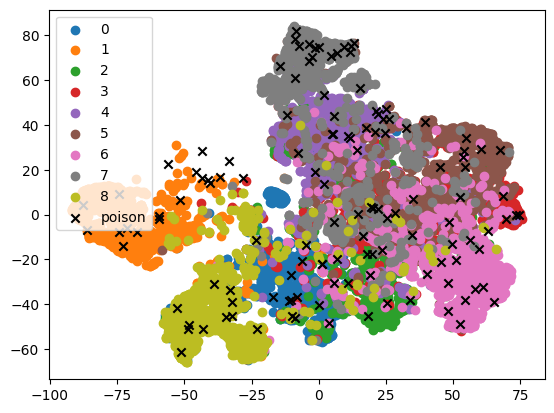

Epoch [171/300]	
	Step [0/391]	 Loss: 3.5965
	Step [50/391]	 Loss: 3.59418
	Step [100/391]	 Loss: 3.61318
	Step [150/391]	 Loss: 3.59852
	Step [200/391]	 Loss: 3.59594
	Step [250/391]	 Loss: 3.59327
	Step [300/391]	 Loss: 3.59399
	Step [350/391]	 Loss: 3.59659

	Training Loss: 3.5943314340108494
	Time Taken: 3.6396666765213013 minutes
Epoch [172/300]	
	Step [0/391]	 Loss: 3.59943
	Step [50/391]	 Loss: 3.59264
	Step [100/391]	 Loss: 3.5962
	Step [150/391]	 Loss: 3.59944
	Step [200/391]	 Loss: 3.59711
	Step [250/391]	 Loss: 3.59309
	Step [300/391]	 Loss: 3.59804
	Step [350/391]	 Loss: 3.59229

	Training Loss: 3.594448767659609
	Time Taken: 3.623299980163574 minutes
Epoch [173/300]	
	Step [0/391]	 Loss: 3.59905
	Step [50/391]	 Loss: 3.59577
	Step [100/391]	 Loss: 3.59236
	Step [150/391]	 Loss: 3.59354
	Step [200/391]	 Loss: 3.5969
	Step [250/391]	 Loss: 3.58943
	Step [300/391]	 Loss: 3.59394
	Step [350/391]	 Loss: 3.5976

	Training Loss: 3.59421884983092
	Time Taken: 3.629600008328756 min

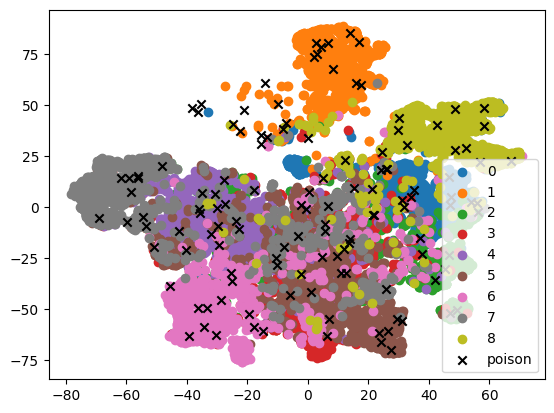

Epoch [181/300]	
	Step [0/391]	 Loss: 3.58935
	Step [50/391]	 Loss: 3.60138
	Step [100/391]	 Loss: 3.59459
	Step [150/391]	 Loss: 3.59383
	Step [200/391]	 Loss: 3.59402
	Step [250/391]	 Loss: 3.59088
	Step [300/391]	 Loss: 3.59228
	Step [350/391]	 Loss: 3.5914

	Training Loss: 3.5930319759242066
	Time Taken: 3.754999498526255 minutes
Epoch [182/300]	
	Step [0/391]	 Loss: 3.59626
	Step [50/391]	 Loss: 3.59886
	Step [100/391]	 Loss: 3.59212
	Step [150/391]	 Loss: 3.58834
	Step [200/391]	 Loss: 3.59731
	Step [250/391]	 Loss: 3.59318
	Step [300/391]	 Loss: 3.59752
	Step [350/391]	 Loss: 3.59502

	Training Loss: 3.5930208726917083
	Time Taken: 3.766450003782908 minutes
Epoch [183/300]	
	Step [0/391]	 Loss: 3.59145
	Step [50/391]	 Loss: 3.58951
	Step [100/391]	 Loss: 3.59822
	Step [150/391]	 Loss: 3.59933
	Step [200/391]	 Loss: 3.59018
	Step [250/391]	 Loss: 3.59885
	Step [300/391]	 Loss: 3.59377
	Step [350/391]	 Loss: 3.59294

	Training Loss: 3.593384836031043
	Time Taken: 3.731699991226196

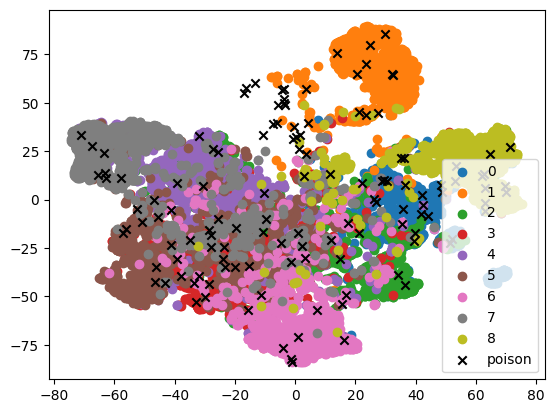

Epoch [191/300]	
	Step [0/391]	 Loss: 3.59292
	Step [50/391]	 Loss: 3.59766
	Step [100/391]	 Loss: 3.59307
	Step [150/391]	 Loss: 3.59347
	Step [200/391]	 Loss: 3.59121
	Step [250/391]	 Loss: 3.59274
	Step [300/391]	 Loss: 3.60012
	Step [350/391]	 Loss: 3.59025

	Training Loss: 3.5923431511120416
	Time Taken: 3.7455853462219237 minutes
Epoch [192/300]	
	Step [0/391]	 Loss: 3.5905
	Step [50/391]	 Loss: 3.58914
	Step [100/391]	 Loss: 3.59185
	Step [150/391]	 Loss: 3.59173
	Step [200/391]	 Loss: 3.59129
	Step [250/391]	 Loss: 3.59343
	Step [300/391]	 Loss: 3.59486
	Step [350/391]	 Loss: 3.59172

	Training Loss: 3.592144058183636
	Time Taken: 3.746704014142354 minutes
Epoch [193/300]	
	Step [0/391]	 Loss: 3.59315
	Step [50/391]	 Loss: 3.59324
	Step [100/391]	 Loss: 3.59104
	Step [150/391]	 Loss: 3.5927
	Step [200/391]	 Loss: 3.59027
	Step [250/391]	 Loss: 3.59487
	Step [300/391]	 Loss: 3.59015
	Step [350/391]	 Loss: 3.59391

	Training Loss: 3.592098230596089
	Time Taken: 3.722965737183889 

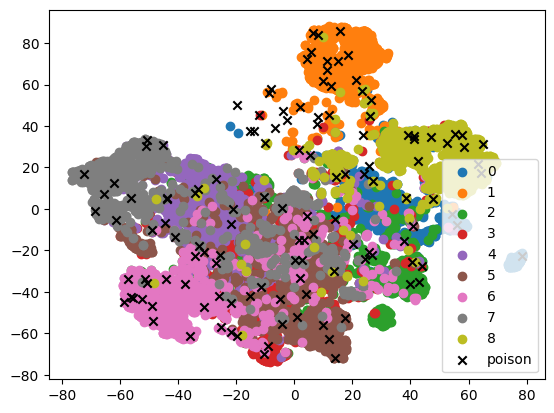

Epoch [201/300]	
	Step [0/391]	 Loss: 3.587
	Step [50/391]	 Loss: 3.5939
	Step [100/391]	 Loss: 3.58968
	Step [150/391]	 Loss: 3.59101
	Step [200/391]	 Loss: 3.59288
	Step [250/391]	 Loss: 3.59187
	Step [300/391]	 Loss: 3.59053
	Step [350/391]	 Loss: 3.59801

	Training Loss: 3.5914443545329298
	Time Taken: 3.761019237836202 minutes
Epoch [202/300]	
	Step [0/391]	 Loss: 3.59007
	Step [50/391]	 Loss: 3.59094
	Step [100/391]	 Loss: 3.59024
	Step [150/391]	 Loss: 3.59515
	Step [200/391]	 Loss: 3.59469
	Step [250/391]	 Loss: 3.59428
	Step [300/391]	 Loss: 3.59388
	Step [350/391]	 Loss: 3.59039

	Training Loss: 3.591492498622221
	Time Taken: 3.7482945958773297 minutes
Epoch [203/300]	
	Step [0/391]	 Loss: 3.58904
	Step [50/391]	 Loss: 3.58834
	Step [100/391]	 Loss: 3.59224
	Step [150/391]	 Loss: 3.5884
	Step [200/391]	 Loss: 3.59061
	Step [250/391]	 Loss: 3.59667
	Step [300/391]	 Loss: 3.59115
	Step [350/391]	 Loss: 3.59326

	Training Loss: 3.5910196621399706
	Time Taken: 3.7316455046335855 

KeyboardInterrupt: 

In [42]:
losses = []

for epoch in range(start_epoch, epochs+1):
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    loss = train(dataloader, model, criterion, optimizer)
    losses.append(loss)

    if epoch <= 10:
        warmupscheduler.step()
    if epoch > 10:
        mainscheduler.step()
    
    print()
    print(f"\tTraining Loss: {loss}")
    time_taken = (time.time()-stime)/60
    print(f"\tTime Taken: {time_taken} minutes")

    if (epoch) % 10 == 0:
        save_model(model, optimizer, mainscheduler, epoch, f"NEW-SimCLR-{epoch}.pt")
        plot_features(model, dataloader_no_contrastive, 100)

## end training
save_model(model, optimizer, mainscheduler, epochs, f"NEW-SimCLR.pt-{epoch}")